In [32]:
# Jessie's branch

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, log_loss
)
from lightgbm import LGBMClassifier

CLASS_NAMES = {
    1: "Spruce/Fir",
    2: "Lodgepole Pine",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz",
}
LABELS          = list(range(1, 8))
CLASS_NAME_LIST = [CLASS_NAMES[i] for i in LABELS]
N_CLASSES       = 7

print("Imports done.")

Imports done.


## 1. Data & Model Setup (mirroring Modeling.ipynb)

In [34]:
train = pd.read_csv('Data/train.csv')

X = train.drop(columns="Cover_Type")
y = train["Cover_Type"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y
)

num_cols = train.loc[:, "Elevation":"Horizontal_Distance_To_Fire_Points"].columns
cat_cols = train.loc[:, "Wilderness_Area1":"Soil_Type40"].columns

no_preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', 'passthrough', cat_cols),
    ],
    remainder='drop'
)

# Best LightGBM params from Modeling.ipynb (RandomSearch + GridSearch, CV acc ~0.867)
model = Pipeline([
    ('prep', no_preprocess),
    ('model', LGBMClassifier(
        objective='multiclass',
        n_estimators=314,
        learning_rate=0.11447627340012448,
        num_leaves=96,
        min_child_samples=78,
        max_depth=-1,
        colsample_bytree=0.9312901539863683,
        subsample=0.7094287557060203,
        reg_alpha=0.012709563372047594,
        reg_lambda=0.10789142699330445,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)

feature_names = [n.split('__', 1)[1] for n in model['prep'].get_feature_names_out()]

print(f"Train: {len(X_train):,}  Val: {len(X_val):,}  Val accuracy: {accuracy_score(y_val, y_pred):.4f}")

c:\Users\Jessie\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Jessie\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train: 13,608  Val: 1,512  Val accuracy: 0.8730


In [ ]:
''' # Subsitute with this after combination
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)

feature_names = [n.split('__', 1)[1] for n in best_model['prep'].get_feature_names_out()]

print(f"Train: {len(X_train):,}  Val: {len(X_val):,}  Val accuracy: {accuracy_score(y_val, y_pred):.4f}")
'''

## 2. Overall metrics

In [35]:
print(f"Accuracy      : {accuracy_score(y_val, y_pred):.4f}")
print(f"Macro F1      : {f1_score(y_val, y_pred, average='macro'):.4f}")
print(f"Weighted F1   : {f1_score(y_val, y_pred, average='weighted'):.4f}")
print(f"Macro Precision: {precision_score(y_val, y_pred, average='macro'):.4f}")
print(f"Macro Recall  : {recall_score(y_val, y_pred, average='macro'):.4f}")
print(f"Macro ROC-AUC : {roc_auc_score(y_val, y_prob, multi_class='ovr', average='macro', labels=LABELS):.4f}")
print(f"Log-loss      : {log_loss(y_val, y_prob, labels=LABELS):.4f}")

Accuracy      : 0.8730
Macro F1      : 0.8725
Weighted F1   : 0.8725
Macro Precision: 0.8722
Macro Recall  : 0.8730
Macro ROC-AUC : 0.9865
Log-loss      : 0.4400


## 3. Per-class report

In [36]:
print(classification_report(y_val, y_pred, labels=LABELS, target_names=CLASS_NAME_LIST))

# Also as a sortable DataFrame — sorted by F1 ascending (weakest class first)
report_dict = classification_report(
    y_val, y_pred, labels=LABELS, target_names=CLASS_NAME_LIST, output_dict=True
)
df_report = (
    pd.DataFrame(report_dict)
    .T.loc[CLASS_NAME_LIST, ["precision", "recall", "f1-score", "support"]]
    .sort_values("f1-score")
)
display(
    df_report.style
    .background_gradient(cmap="RdYlGn", subset=["precision", "recall", "f1-score"])
    .format({"precision": "{:.3f}", "recall": "{:.3f}", "f1-score": "{:.3f}", "support": "{:.0f}"})
)

                   precision    recall  f1-score   support

       Spruce/Fir       0.76      0.76      0.76       216
   Lodgepole Pine       0.75      0.71      0.73       216
   Ponderosa Pine       0.88      0.89      0.89       216
Cottonwood/Willow       0.95      0.96      0.95       216
            Aspen       0.92      0.94      0.93       216
      Douglas-fir       0.89      0.91      0.90       216
        Krummholz       0.96      0.94      0.95       216

         accuracy                           0.87      1512
        macro avg       0.87      0.87      0.87      1512
     weighted avg       0.87      0.87      0.87      1512



,precision,recall,f1-score,support
Lodgepole Pine,0.748,0.713,0.730,216
Spruce/Fir,0.764,0.764,0.764,216
Ponderosa Pine,0.877,0.894,0.885,216
Douglas-fir,0.891,0.912,0.902,216
Aspen,0.918,0.935,0.927,216
Krummholz,0.962,0.935,0.948,216
Cottonwood/Willow,0.945,0.958,0.952,216


## 4. Confusion matrix

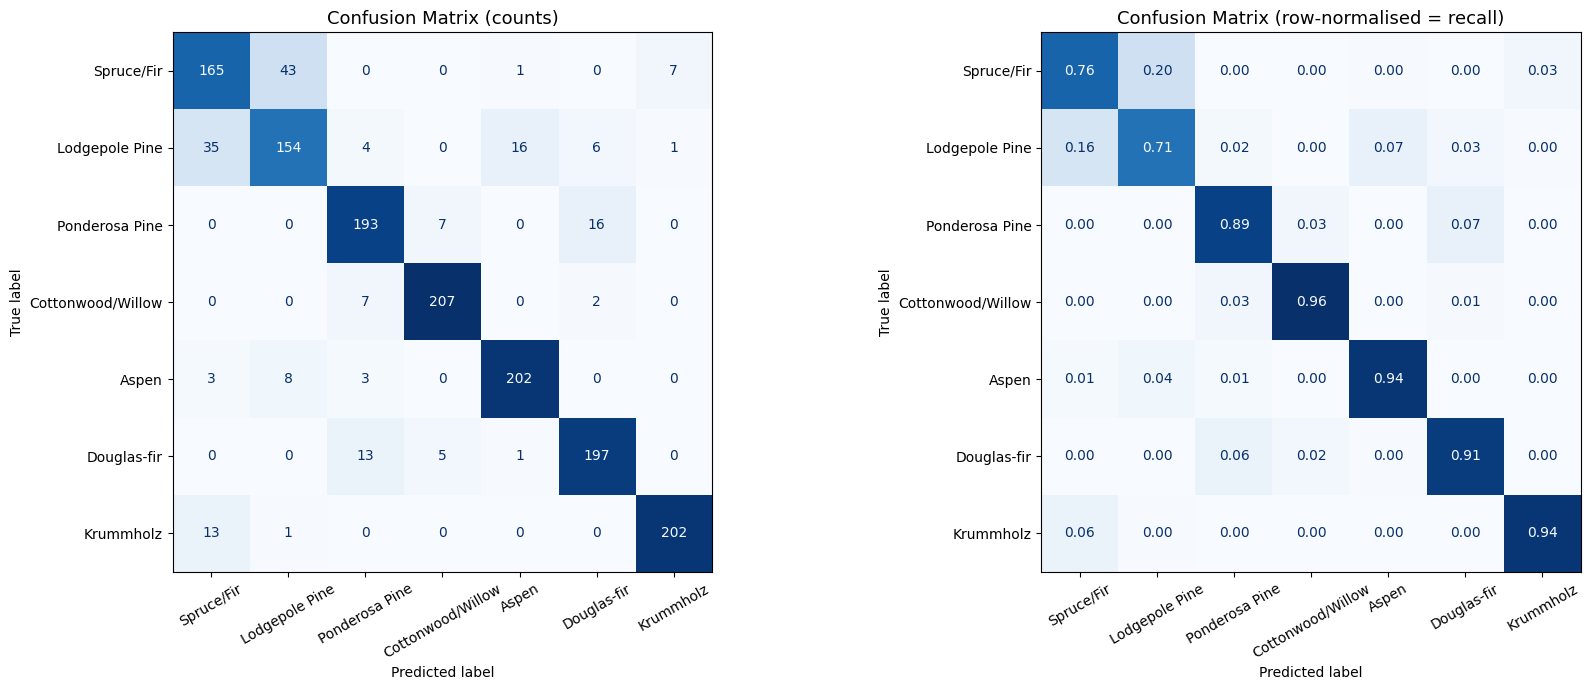

In [37]:
cm = confusion_matrix(y_val, y_pred, labels=LABELS)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ── Left: raw counts ──────────────────────────────────────────────────────────
ConfusionMatrixDisplay(cm, display_labels=CLASS_NAME_LIST).plot(
    ax=axes[0], cmap="Blues", colorbar=False, xticks_rotation=30
)
axes[0].set_title("Confusion Matrix (counts)", fontsize=13)

# ── Right: row-normalised (recall per class on diagonal) ──────────────────────
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm_norm, display_labels=CLASS_NAME_LIST).plot(
    ax=axes[1], cmap="Blues", colorbar=False, xticks_rotation=30, values_format=".2f"
)
axes[1].set_title("Confusion Matrix (row-normalised = recall)", fontsize=13)

plt.tight_layout()
plt.show()

## 5. Top-N most confused class pairs

In [38]:
TOP_N = 10  # change as needed

rows, cols = np.where(~np.eye(N_CLASSES, dtype=bool))
confusion_pairs = sorted(
    [(cm[r, c], CLASS_NAME_LIST[r], CLASS_NAME_LIST[c]) for r, c in zip(rows, cols)],
    reverse=True
)

print(f"Top-{TOP_N} off-diagonal confusion pairs (true → predicted):")
print(f"{'Count':>7}  {'True class':<22}  {'Predicted as'}")
print("-" * 55)
for count, true_cls, pred_cls in confusion_pairs[:TOP_N]:
    print(f"{count:>7}  {true_cls:<22}  {pred_cls}")

Top-10 off-diagonal confusion pairs (true → predicted):
  Count  True class              Predicted as
-------------------------------------------------------
     43  Spruce/Fir              Lodgepole Pine
     35  Lodgepole Pine          Spruce/Fir
     16  Ponderosa Pine          Douglas-fir
     16  Lodgepole Pine          Aspen
     13  Krummholz               Spruce/Fir
     13  Douglas-fir             Ponderosa Pine
      8  Aspen                   Lodgepole Pine
      7  Spruce/Fir              Krummholz
      7  Ponderosa Pine          Cottonwood/Willow
      7  Cottonwood/Willow       Ponderosa Pine


## 6. Feature importance

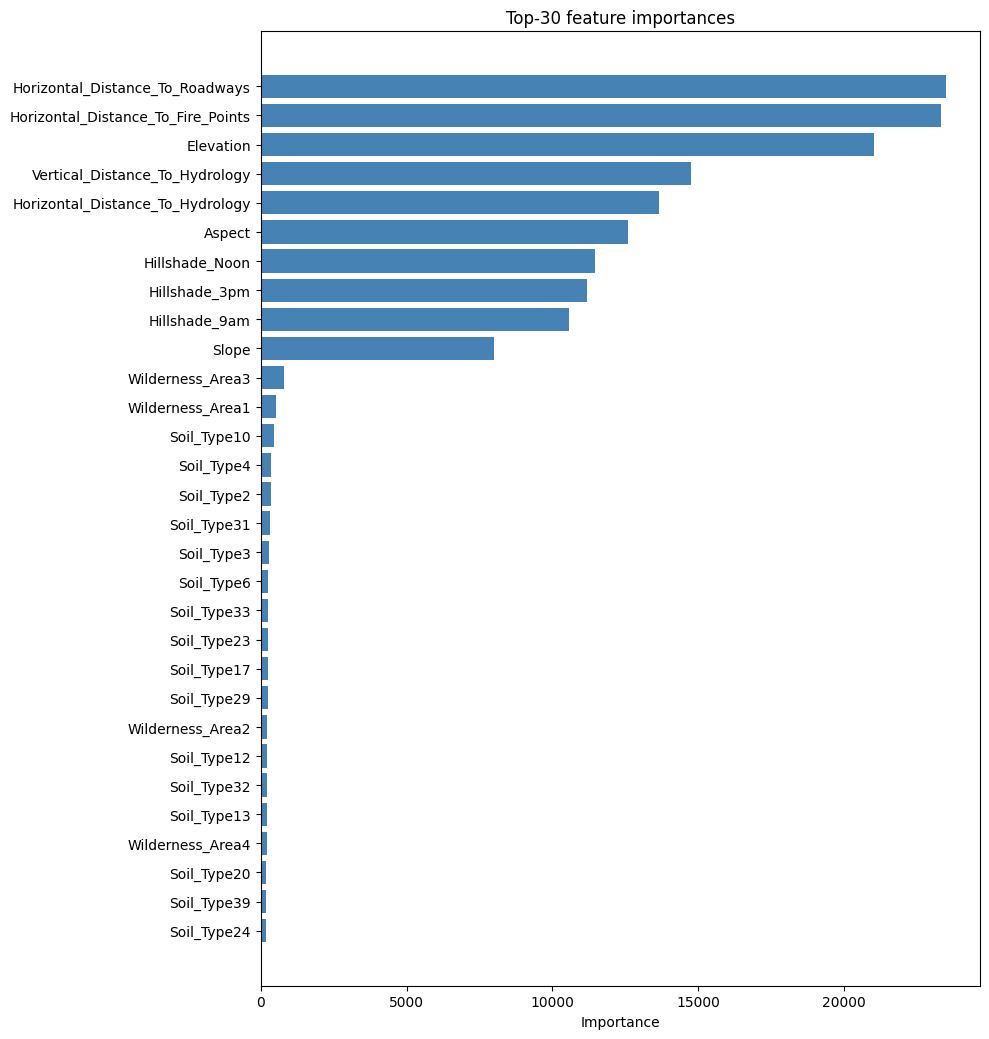

,feature,importance
0,Horizontal_Distance_To_Roadways,23478
1,Horizontal_Distance_To_Fire_Points,23318
2,Elevation,21014
3,Vertical_Distance_To_Hydrology,14761
4,Horizontal_Distance_To_Hydrology,13639
5,Aspect,12581
6,Hillshade_Noon,11465
7,Hillshade_3pm,11180
8,Hillshade_9am,10563
9,Slope,7984


In [39]:
TOP_FEATURES = 30

def plot_feature_importance(pipeline, feat_names, top_n=TOP_FEATURES):
    importances = pipeline['model'].feature_importances_
    idx = np.argsort(importances)[::-1][:top_n]

    fig, ax = plt.subplots(figsize=(10, top_n * 0.35))
    ax.barh([feat_names[i] for i in reversed(idx)], importances[idx[::-1]], color="steelblue")
    ax.set_xlabel("Importance")
    ax.set_title(f"Top-{top_n} feature importances")
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({"feature": [feat_names[i] for i in idx], "importance": importances[idx]})

fi_df = plot_feature_importance(model, feature_names)
display(fi_df.head(20))

## 7. Error analysis — inspect misclassified samples

In [40]:
y_val_arr  = np.asarray(y_val)
y_pred_arr = np.asarray(y_pred)

errors_df = X_val.copy()
errors_df["true"]       = [CLASS_NAMES[i] for i in y_val_arr]
errors_df["predicted"]  = [CLASS_NAMES[i] for i in y_pred_arr]
errors_df["confidence"] = y_prob.max(axis=1)
errors_df = errors_df[y_val_arr != y_pred_arr]

print(f"Misclassified: {len(errors_df)} / {len(y_val_arr)} ({len(errors_df)/len(y_val_arr)*100:.1f}%)")
print("\nError rate per class:")
print(errors_df["true"].value_counts() / pd.Series(y_val_arr).map(CLASS_NAMES).value_counts())

display(errors_df[["true", "predicted", "confidence"]].head(10))

Misclassified: 192 / 1512 (12.7%)

Error rate per class:
Aspen                0.064815
Cottonwood/Willow    0.041667
Douglas-fir          0.087963
Krummholz            0.064815
Lodgepole Pine       0.287037
Ponderosa Pine       0.106481
Spruce/Fir           0.236111
Name: count, dtype: float64


,true,predicted,confidence
2500,Lodgepole Pine,Aspen,0.954841
5824,Ponderosa Pine,Cottonwood/Willow,0.722247
4416,Ponderosa Pine,Cottonwood/Willow,0.502578
3737,Lodgepole Pine,Spruce/Fir,0.996747
6744,Cottonwood/Willow,Ponderosa Pine,0.996945
9575,Aspen,Ponderosa Pine,0.987597
2753,Lodgepole Pine,Aspen,0.970565
2816,Lodgepole Pine,Spruce/Fir,0.581488
13102,Krummholz,Spruce/Fir,0.999415
1256,Spruce/Fir,Lodgepole Pine,0.996249


## 8. Confidence distribution — is the model uncertain on errors?

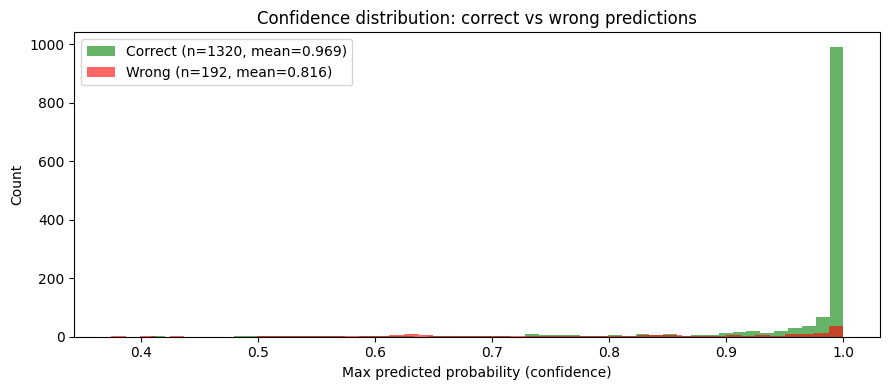

In [41]:
correct_conf = y_prob.max(axis=1)[y_val_arr == y_pred_arr]
wrong_conf   = y_prob.max(axis=1)[y_val_arr != y_pred_arr]

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(correct_conf, bins=50, alpha=0.6, color="green", label=f"Correct (n={len(correct_conf)}, mean={correct_conf.mean():.3f})")
ax.hist(wrong_conf,   bins=50, alpha=0.6, color="red",   label=f"Wrong (n={len(wrong_conf)}, mean={wrong_conf.mean():.3f})")
ax.set_xlabel("Max predicted probability (confidence)")
ax.set_ylabel("Count")
ax.set_title("Confidence distribution: correct vs wrong predictions")
ax.legend()
plt.tight_layout()
plt.show()